In [1]:
!pip install imageio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [66]:
import os
import cv2
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Project1. 직접 고른 이미지로 SRGAN 실험하기

> LMS에서 'DIV2K' 학습 데이터셋을 기반으로 사전 학습한 SRGAN 모델을 읽은 후 메모리에 적재한다.

In [3]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

> SRGAN 모델을 편리하게 사용할 수 있도록 사용자 정의 함수를 구현한다.

In [4]:
def use_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    
    return np.array(sr)[0]

## project 1-1. Bicubic과 SRGAN의 복원 이미지와 원본 이미지 비교 실험(고화질 이미지)

## 1. High resolution image load

> QHD급 화질 이상의 높은 해상도 이미지 데이터를 load후 메모리에 적재한다.

In [5]:
img_path = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex16/rome.jpg'
rome_image = cv2.imread(img_path)
rome_image = cv2.cvtColor(rome_image, cv2.COLOR_BGR2RGB)

> 불러온 원본 이미지를 확인하고 동시에, shape로 원본 이미지의 벡터를 확인했다.

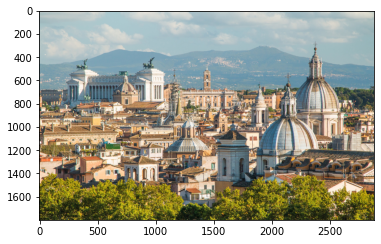

(1800, 2880, 3)
None


In [11]:
plt.imshow(rome_image)
plt.show()
print(print(rome_image.shape))

> 2880x1800 해상도의 컬러 이미지 객체가 생성된 모습을 확인할 수 있다.

# 2. 사용자 정의 함수

> 프로젝트 진행에 편의성 증대를 위한 사용자 기능 함수를 구현한다.

### 2.1 Super Resolution 결과 평가 함수

> Bicubic, SRGAN모델 각각이 만들어낸 이미지와 원본 이미지를 비교하기 위해 Super Resolution결과를 평가할 함수를 구현한다.<br>
> Super Resolution 결과를 정량적인 평가 척도로 PSNR과 SSIM가 주로 사용된다.<br><br>
> PSNR는 영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음(noise)의 비율을 나타내며 영상을 압축했을 때 화질이 얼마나 손실되었는지 평가하는 목적으로 사용된다. PSNR 수치가 높을수록 원본 영상에 비해 손실이 적다는 의미로 값이 높을수록 좋다.<br><br>
> SSIM은 영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산한다. 이는 SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미이다.

In [9]:
print("PSNR :", peak_signal_noise_ratio(rome_image, rome_image))
print("SSIM :", structural_similarity(rome_image, rome_image, multichannel=True))

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


PSNR : inf
SSIM : 1.0


> 원본과 원본을 비교했을때 두 지표 모두 최고값을 보여주며, 평가 기능이 정상적으로 동작함을 확인할 수 있다.

### 2.2 Image upsampling and downsampling

> 이미지의 크기를 증가 또는 감소할 수 있는 기능 함수를 구현한다.

### 2.2.1 Use bicubic interpolation for Image upsampling

> 이미지의 픽셀 개수를 증감할 배수를 입력받아 이미지를 bicubic interpolation기법으로 업샘플링 하는 기능 함수를 구현한다.

In [16]:
def image_upsample_bicubic(image, n):
    upsample = cv2.resize(image, dsize=(image.shape[1]*n, image.shape[0]*n),interpolation=cv2.INTER_CUBIC)
    return upsample

### 2.2.2 Image downsampling function

> 이미지와 픽셀 개수를 감소할 배수를 입력받아 이미지를 다운샘플링 하는 기능 함수를 구현한다.

In [13]:
def image_downsample(image, n):
    downsample = cv2.resize(image, dsize=(image.shape[1]//n, image.shape[0]//n))
    return downsample

### 2.2.3 Image crop function

> 이미지의 특정 부분을 잘라내는 기능을 수행하는 사용자 정의 함수를 구현한다.

In [29]:
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

## 3. bicubic과 SRGAN 모델기반 이미지 복원 후 원본 이미지와 비교

### 3.1 Restoration after image loss for bicubic interpolation

> 원본 이미지의 픽셀 데이터를 1/4로 다운샘플링 후, bicubic interpolation기법을 활용하여 이미지를 복원하는 실험을 진행한다.

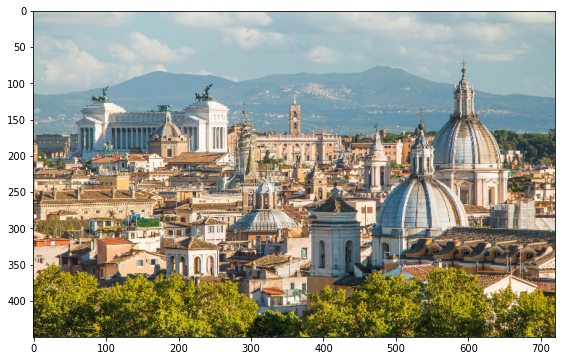

(450, 720, 3)


In [15]:
down_rome_image = image_downsample(rome_image, 4)
plt.figure(figsize=(10,6))
plt.imshow(down_rome_image)
plt.show()
print(down_rome_image.shape)

> 원본 이미지의 픽셀수를 1/4로 다운 샘플링 후, 이미지를 확인한 결과 색상 채널을 유지한 채 해상도가 1/4로 잘 감소했음을 확인할 수 있다.<br>
> 다운샘플링된 위 이미지를 활용하여 bicubic interpolation기법으로 다시 해상도를 4배 증가하는 이미지 업샘플링 과정을 수행한다.

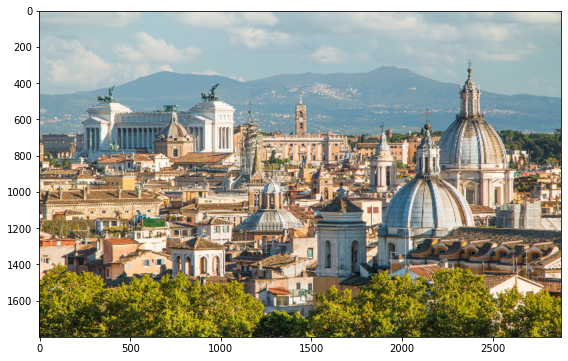

(1800, 2880, 3)


In [17]:
bicubic_rome_image = image_upsample_bicubic(down_rome_image, 4)
plt.figure(figsize=(10,6))
plt.imshow(bicubic_rome_image)
plt.show()
print(bicubic_rome_image.shape)

> bicubic interpolation기법으로 이미지를 업샘플링한 결과 원본과 동일한 해상도를 다시 얻을 수 있었다.<br>
> 복원이 얼마나 잘 수행되었는지 확인하기 위해 PSNR과 SSIM지표를 활용하여 원본과 bicubic interpolation모델이 복원한 이미지를 비교한다.

In [18]:
print("PSNR :", peak_signal_noise_ratio(rome_image, bicubic_rome_image))
print("SSIM :", structural_similarity(rome_image, bicubic_rome_image, multichannel=True))

PSNR : 21.90630121207213
SSIM : 0.7019745736343735


> PSNR은 21.9, SSIM은 0.7의 지표 결과값을 보여주었다.<br><br>
> PSNR은 수치가 높을수록 원본 영상에 비해 손실이 적다는 의미이므로 꽤 좋은 결과값이라 생각한다.<br>
> SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미로, 0.7의 결과값은 원본의 70% 품질을 복원했음을 확인할 수 있다.

### 3.2 Restoration after image loss for SRGAN

> 원본 이미지의 픽셀 데이터를 1/4로 다운샘플링 후, SRGAN기법을 활용하여 이미지를 복원하는 실험을 진행한다.

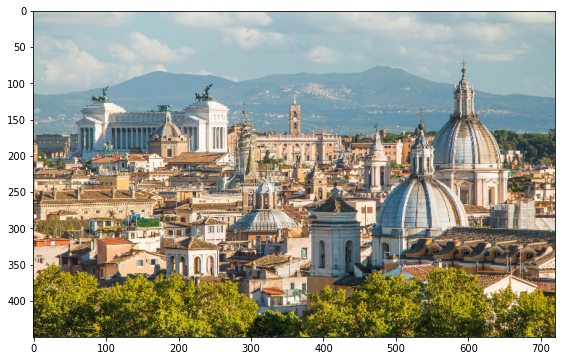

(450, 720, 3)


In [19]:
down_rome_image = image_downsample(rome_image, 4)
plt.figure(figsize=(10,6))
plt.imshow(down_rome_image)
plt.show()
print(down_rome_image.shape)

> 원본 이미지의 픽셀수를 1/4로 다운 샘플링 후, 이미지를 확인한 결과 색상 채널을 유지한 채 해상도가 1/4로 잘 감소했음을 확인할 수 있다.<br>
> 다운샘플링된 위 이미지를 활용하여 SRGAN기법으로 이미지 업샘플링하여 복원하는 과정을 수행한다.

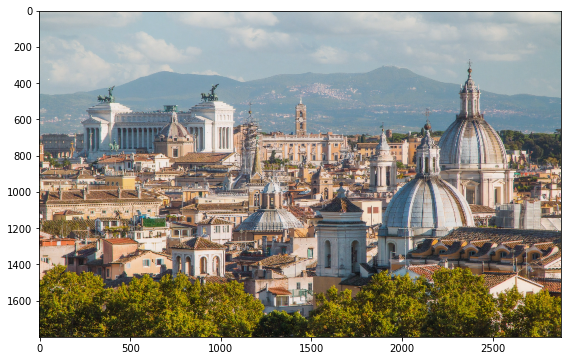

(1800, 2880, 3)


In [23]:
srgan_rome_image = use_srgan(down_rome_image)
plt.figure(figsize=(10,6))
plt.imshow(srgan_rome_image)
plt.show()
print(srgan_rome_image.shape)

> SRGAN기법으로 이미지를 업샘플링한 결과 원본과 동일한 해상도를 다시 얻을 수 있었다.<br>
> 복원이 얼마나 잘 수행되었는지 확인하기 위해 PSNR과 SSIM지표를 활용하여 원본과 SGRAN모델이 복원한 이미지를 비교한다.

In [24]:
print("PSNR :", peak_signal_noise_ratio(rome_image, srgan_rome_image))
print("SSIM :", structural_similarity(rome_image, srgan_rome_image, multichannel=True))

PSNR : 18.184902813088993
SSIM : 0.5175718761931398


> PSNR은 18.18, SSIM은 0.51의 지표 결과값을 보여주었다.<br><br>
> PSNR은 수치가 높을수록 원본 영상에 비해 손실이 적다는 의미이므로 무난한 결과값이라 생각한다.<br>
> SSIM값이 높을수록 원본 영상의 품질에 가깝다는 의미로, 0.51의 결과값은 원본의 51% 품질을 복원했음을 확인할 수 있다.<br>
> 그러나 bicubic interpolation기법과 비교했을때, 보다 나쁜 수치를 보여주었다.<br>

### 3.3 Visualize and compare images

> 위 실험으로 객관적인 수치값은 SRGAN이 bicubic interpolation보다 나쁜 결과를 보여주었다.<br>
> 그래도, 실제 이미지 출력 결과도 나쁜지 확인하기 위해 원본 이미지와, bicubic모델의 복원 이미지, SRGAN 모델의 복원 이미지를 비교한다.

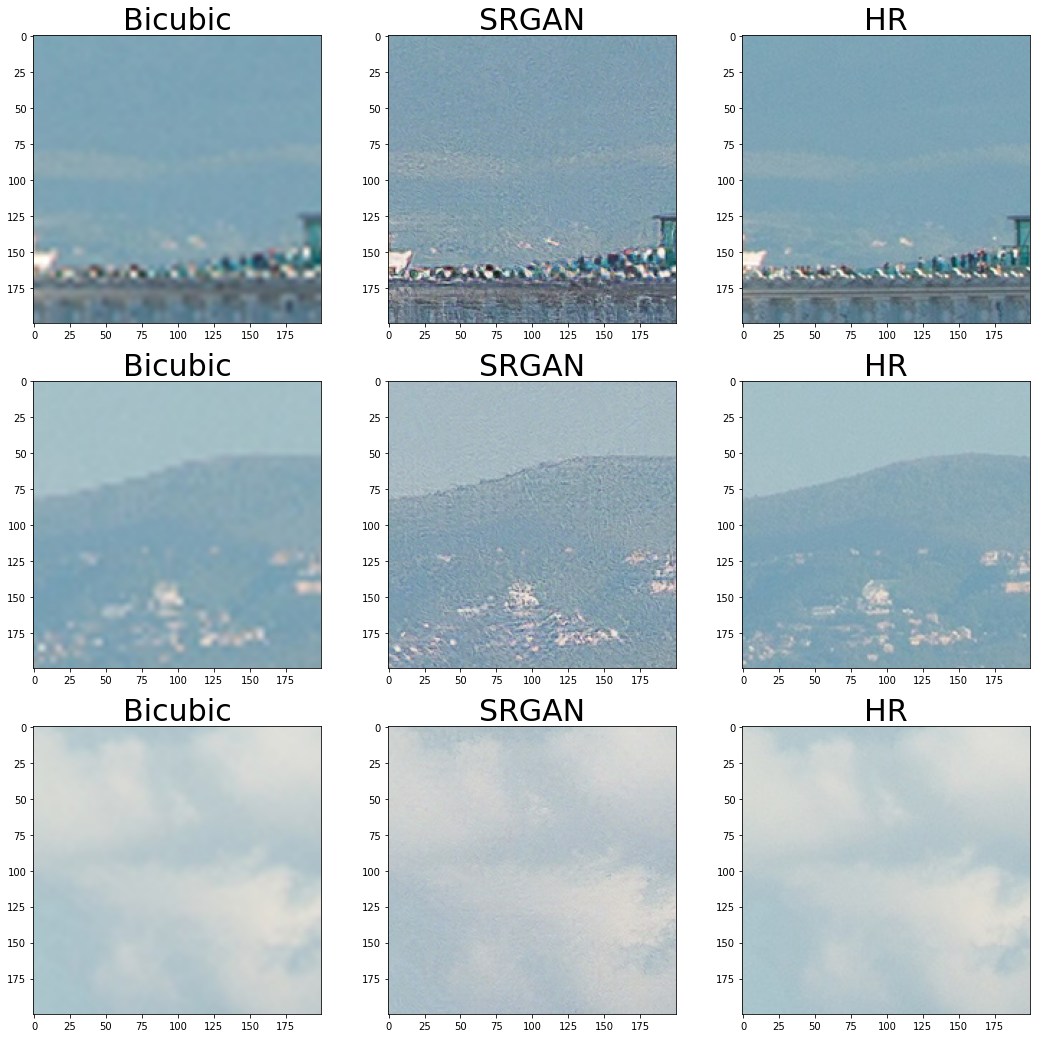

In [30]:
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_rome_image, left_top, 200, 200)
    img2 = crop(srgan_rome_image , left_top, 200, 200)
    img3 = crop(rome_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

> 3개의 이미지를 비교한 결과, 객곽적인 지표인 PSNR과 SSIM에서는 bicubic interpolation모델이 앞선 모습이였으나<br>
> 실체 출력에서는 원본이미지에 비해 흐릿하고 선명하지 않은 이미지를 출력한 모습을 확인할 수 있다.<br><br>
> 반면 PSNR과 SSIM에서 bicubic모델에 비해 나쁜 결과를 보여주었던 SRGAN 모델이 출력한 이미지는<br>
> bicubic모델이 생상한 이미지보다 자연스럽고 선명한 이미지를 출력하는 결과를 확인할 수 있다.

> 실험으로 위와 같은 결과가 나온 이유는, 픽셀 구성 방법의 차이라고 생각한다.<br><br>
> bicubic interpolation모델은 인근 픽셀의 색상과 유사한 색상으로 이미지를 복원하지만,<br>
> SRGAN 모델은 사진의 노이즈 기반 픽셀 구성 패턴을 기준으로 이미지를 복원한다.<br><br>
> 이는 실제 원본사진에서 먼 거리에 있는 물체는 원근법에 의해, 선명하지 않고 흐릿해지며, 픽셀이 뭉개지는 현상이 나타나는데,<br>
> bicubic interpolation모델은 인근 픽셀 색상으로 복원하므로, 색상 유사도는 원본과 비슷할지언정 선명도는 떨어지는 결과를 보여준다.<br>
> 반면 SRGAN 모델은 픽셀의 구성 패턴으로 복원하므로, 색상 유사도는 원본과 차이가 있을지언정, 선명도는 높은 결과를 보여준다.<br>

## project 1-2. Bicubic과 SRGAN의 복원 이미지와 원본 이미지 비교 실험(저화질 이미지)

## 1. Low resolution image load

> SD급 화질의 낮은 해상도 이미지 데이터를 load후 메모리에 적재한다.

In [58]:
img_path = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex16/hogug.jpg'
hogug_image = cv2.imread(img_path)
hogug_image = cv2.cvtColor(hogug_image, cv2.COLOR_BGR2RGB)

> 불러온 원본 이미지를 확인하고 동시에, shape로 원본 이미지의 벡터를 확인했다.

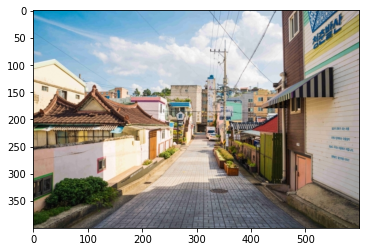

(400, 600, 3)
None


In [59]:
plt.imshow(hogug_image)
plt.show()
print(print(hogug_image.shape))

> 600x400 해상도의 컬러 이미지 객체가 생성된 모습을 확인할 수 있다.

## 2. bicubic과 SRGAN 모델기반 이미지 업샘플링 후 비교

### 2.1 Restoration image for bicubic interpolation

> 원본 저해상도 이미지를 bicubic interpolation기법을 활용하여 이미지를 고해상도로 변환하는 업샘플링 작업을 진행한다.

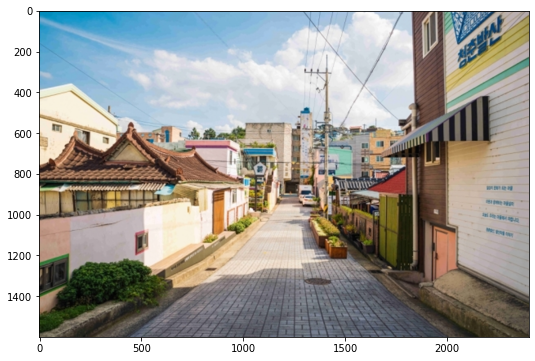

(1600, 2400, 3)


In [60]:
bicubic_hogug_image = image_upsample_bicubic(hogug_image, 4)
plt.figure(figsize=(10,6))
plt.imshow(bicubic_hogug_image)
plt.show()
print(bicubic_hogug_image.shape)

> bicubic interpolation기법으로 이미지를 업샘플링한 결과 QHD급 해상도를 얻을 수 있었다.<br>

### 2.2 Restoration image for SRGAN

> 원본 저해상도 이미지를 SRGAN기법을 활용하여 이미지를 고해상도로 변환하는 업샘플링 작업을 진행한다.

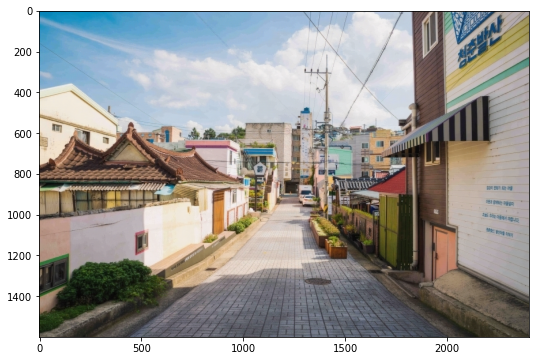

(1600, 2400, 3)


In [61]:
srgan_hogug_image = use_srgan(hogug_image)
plt.figure(figsize=(10,6))
plt.imshow(srgan_hogug_image)
plt.show()
print(srgan_hogug_image.shape)

> SRGAN기법으로 이미지를 업샘플링한 결과 QHD급 해상도를 얻을 수 있었다.<br>

### 2.3 Visualize and compare images

> 저화질의 원본 이미지를 bicubic과 SRGAN 모델로 업샘플링 한 결과를 비교하는 작업을 수행한다.

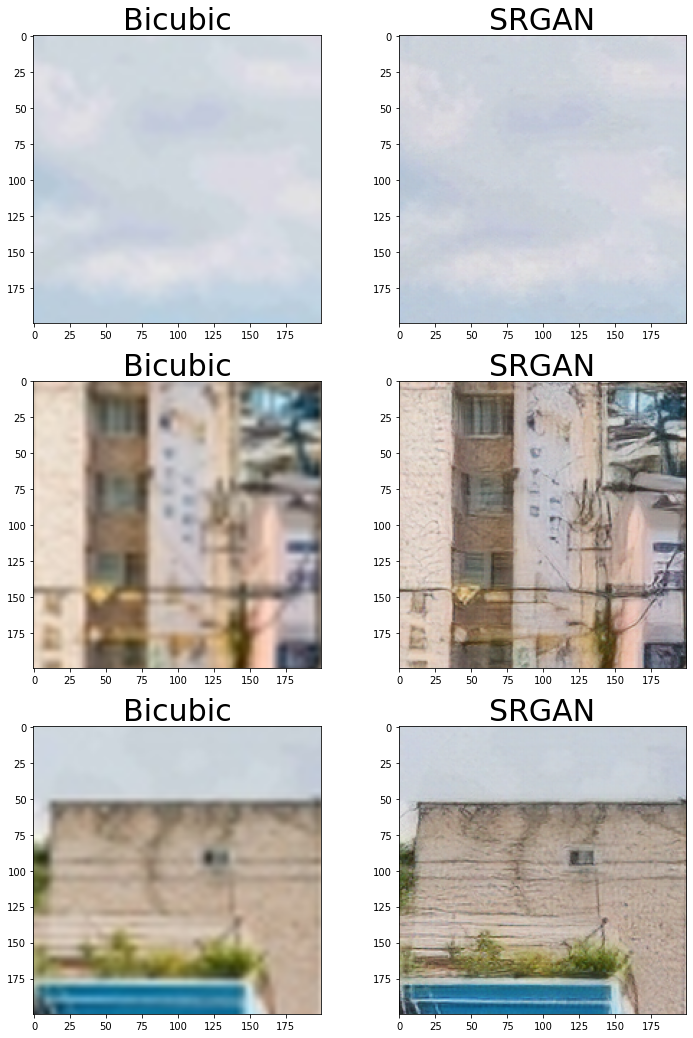

In [62]:
left_tops = [(300,600), (600,1200), (500,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hogug_image, left_top, 200, 200)
    img2 = crop(srgan_hogug_image , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

> bicubic interpolation모델이 업샘플링한 이미지는 흐릿하고 선명하지 않은 이미지를 출력한 모습을 확인할 수 있다.<br>
> SRGAN 모델이 업샘플링한 이미지는 bicubic모델이 생상한 이미지보다 자연스럽고 선명한 이미지를 출력하는 결과를 확인할 수 있다.

> 실험으로 위와 같은 결과가 나온 이유는, 고화질 이미지 실험과 같이 픽셀 구성 방법의 차이라고 생각한다.<br><br>
> bicubic interpolation모델은 인근 픽셀의 색상과 유사한 색상으로 이미지를 복원하지만,<br>
> SRGAN 모델은 사진의 노이즈 기반 픽셀 구성 패턴을 기준으로 이미지를 복원한다.<br><br>
> 이는 실제 원본사진에서 먼 거리에 있는 물체는 원근법에 의해, 선명하지 않고 흐릿해지며, 픽셀이 뭉개지는 현상이 나타나는데,<br>
> bicubic interpolation모델은 인근 픽셀 색상으로 복원하므로, 색상 유사도는 원본과 비슷할지언정 선명도는 떨어지는 결과를 보여준다.<br>
> 반면 SRGAN 모델은 픽셀의 구성 패턴으로 복원하므로, 색상 유사도는 원본과 차이가 있을지언정, 선명도는 높은 결과를 보여준다.<br>

# Project2. SRGAN을 이용해 고해상도 gif 생성

## 1. Cat animation imege data load

> 따뜻한 모닥불의 모습이 담긴 gif파일을 읽은 후 메모리에 적재한다.

In [64]:
gif_path = os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex16/fire.gif'
gif_image = cv2.VideoCapture(gif_path)

## 2. Apply Super Resolution by frame.

> Bicubic interpolation과 SRGAN을 활용하여 원본 gif의 해상도를 4배 증가하는 공정을 수행후, 출력 값을 저장한다.

In [65]:
isTrue = True
frames = []
bicubic_gif = []
srgan_gif = []

while isTrue:
    isTrue, frame = gif_image.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        bicubic_gif.append(image_upsample_bicubic(frame, 4))
        srgan_gif.append(use_srgan(frame))
        

print("frame count :", len(frames))
print("frame size :", (frames[0].shape))
print("bicubic image count :", len(bicubic_gif))
print("bicubic image size :", (bicubic_gif[0].shape))
print("srgan image count :", len(srgan_gif))
print("srgan image size :", (srgan_gif[0].shape))

frame count : 14
frame size : (282, 300, 3)
bicubic image count : 14
bicubic image size : (1128, 1200, 3)
srgan image count : 14
srgan image size : (1128, 1200, 3)


> bicubic 모델과 SRGRAN 모델 모두 원본 대비 해상도가 4배 증가했음을 확인할 수 있다.

## 3. Make gif file

> Super Resolution한 이미지를 GIF 형식의 파일로 해당 경로에 저장한다.<br>
> 원본 GIF의 용량은 1.1MB 이며, bicubic 모델이 생성한 GIF는 15.7MB, SRGRAN 모델은 18.9MB의 용량을 보여주었다.

In [67]:
imageio.mimsave(os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex16/bicubic_HQ.gif', bicubic_gif)
imageio.mimsave(os.getenv('HOME')+'/aiffel/Exploration/ex_Data/ex16/srgan_HQ.gif', srgan_gif)

# 4. Result

> Github의 업로드 크기 제한으로 생성된 GIF 파일은 아래 링크로 확인할 수 있다.<br>
> 원본 GIF : https://drive.google.com/file/d/129PFK8eUNzh1i_fqGsTz85gE6uFDtVoF/view?usp=sharing
> bicubic interpolation 모델 : https://drive.google.com/file/d/1PU9-3D0TNkwxqIb-oQ72cF4gwt30OBMC/view?usp=sharing <br>
> SRGAN 모델 : https://drive.google.com/file/d/1T-GWO_I-PVDX7hIYlAR3CsOsay8de3iM/view?usp=sharing <br>

> bicubic interpolation 모델로 Super Resolution한 GIF는 전체적으로 이미지의 부드러운 느낌을 살린 모습을 보여주었다.<br>
> 아늑하고 따뜻한 모닥불 이미지를 선호한다면 bicubic interpolation 모델을 사용하는게 적합하다고 생각한다.<br><br>
> SRGAN 모델로 Super Resolution한 GIF는 전체적으로 선명도와 명암이 뚜렷한 모습을 보여주었다.<br>
> 강렬하고 진한 분위기의 모닥불 이미지를 선호한다면 SRGAN 모델을 사용하는게 적합하다고 생각한다.<br>

# 후기

> 위 실험을 진행하면서 예전 스마트폰 초창기에 LCD 디스플레이와 AMOLED 디스플레이간의 차이를 두고 사람들간에 여러 의견이 나왔던 모습이 떠올랐습니다.<br>
> LCD 디스플레이는 색상표현이 부드럽지만 AMOLED 디스플레이에 비해 선명도가 부족하고 스스로 발광이 불가능하기에, 백플라이트의 존재로 완벽한 검은색을 구현할 수 없었습니다.<br>
> 반면, AMOLED는 매우 선명한 화면을 출력하고 색재현력이 뛰어난 장점이 있었지만, 너무 선명한 나머지 눈이 아프거나 오히려 색상이 강렬하여 보기 불편하다는 의견도 있었습니다.<br>
> 여러 의견이 오간 결과 두 디스플레이 모두 좋은 디스플레이 이며, 목적에 맞게 원하는 디스플레이를 선택하는것이 좋다하는 결론이 나왔던것으로 기억합니다.<br><br>
> Bicubic interpolation  기법과 SRGAN 기법의 결과를 비교하면서, 두 모델 모두 준수하게 이미지를 복원하는 결과를 출력하는 모습을 보여주었습니다. 때문에 어떤 모델이 더 좋다고는 말하기보다는 사용자가 원하는 이미지에 따라 모델을 선택하는게 좋다고 생각합니다.<br>
> 즉, 목적에 맞게 상황에 알맞은 모델을 선택하는게 좋은 방법이라 생각합니다.<br>